In [2]:
# pytorch로 합성곱 신경망 시각화

# Sequential 클래스를 사용해서 동일한 합성곱 신경망 구현
import torch
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1,32,kernel_size=3,padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32,64,kernel_size=3,padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100,10))



In [3]:
# 저장한 가중치를 로드
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [4]:
# 가중치 로드
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

<All keys matched successfully>

In [5]:
# model 객체의 children() 메서드는 모델에 추가된 층을 반환하는 파이선 제너레이터 객체를 반환
# 따라서 리스트 내포 구문을 사용하면 model 객체의 모든 층을 쉽게 가져올 수 있음
layers = [layer for layer in model.children()]

In [6]:
# 처음 추가한 합성곱 층 출력
print(layers[0])

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [7]:
# Sequential 클래스로 만든 모델은 정수 인덱스로 하위 층을 참조 할 수 있음
model[0]

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [8]:
# 또 다른 방법으로 모델 객체의 named_children() 메서드를 사용하면 층의 이름과 층객체를 함께 얻을 수 있음
for name, layer in model.named_children():
    print(f"{name:10s}", layer)

conv1      Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu1      ReLU()
pool1      MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2      Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
relu2      ReLU()
pool2      MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
flatten    Flatten(start_dim=1, end_dim=-1)
dense1     Linear(in_features=3136, out_features=100, bias=True)
relu3      ReLU()
dropout    Dropout(p=0.3, inplace=False)
dense2     Linear(in_features=100, out_features=10, bias=True)


In [9]:
# 파이토치 모델은 층의 이름을 모델의 속성처럼 사용할 수 있음
model.conv1

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [10]:
# 가중치의 평균과 표준편차 계산
conv_weights = model.conv1.weight.data
print(conv_weights.mean(), conv_weights.std())

tensor(-0.0553) tensor(0.3149)


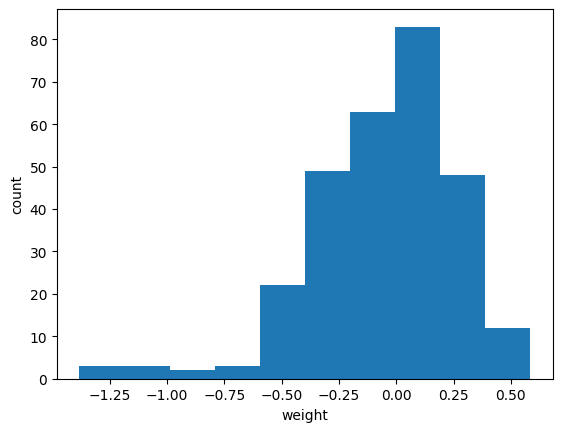

In [11]:
# 히스토그램으로 가중치 값의 분포 확인
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [12]:
# conv_weights의 텐서크기 확인
print(conv_weights.shape)
# 케라스(높이,너비,채널,필더개수) but 파이토치(필터개수,채널,높이,너비)

torch.Size([32, 1, 3, 3])


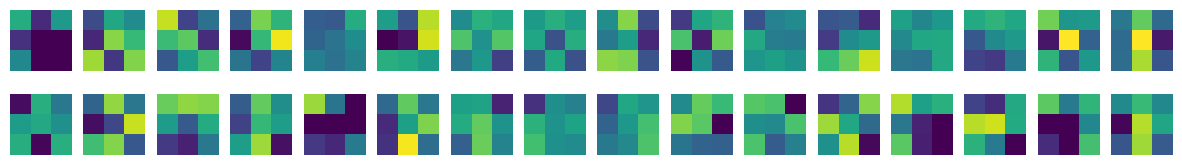

In [13]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weights[i*16+j,0,:,:], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

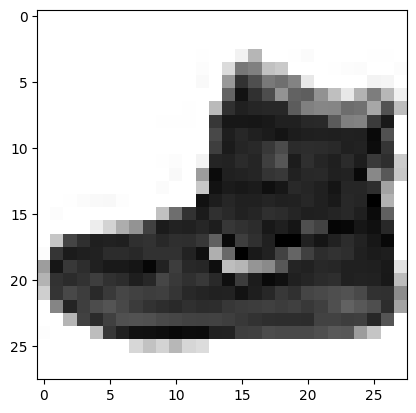

In [14]:
# 패션MNIST 데이터 중 하나를 모델에 통과시키고 합성곱 층이 어떤 활성화 출력을 만드는지 확인
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
train_input = fm_train.data
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [15]:
ankle_boot = train_input[0:1].reshape(1,1,28,28) / 255.0

model.eval()
with torch.no_grad():
    feature_maps = model.conv1(ankle_boot)
    feature_maps = model.relu1(feature_maps)
# feature map의 크기확인
print(feature_maps.shape)

torch.Size([1, 32, 28, 28])


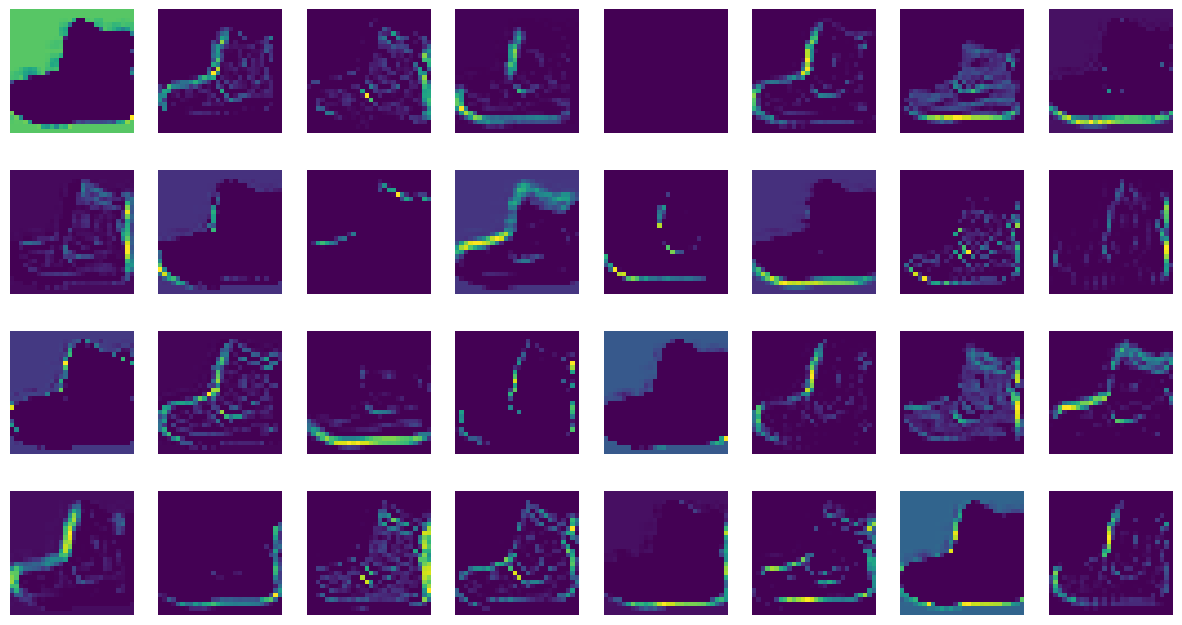

In [16]:
# 특성맵 확인
fig, axs = plt.subplots(4, 8, figsize=(15,8))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,i*8+j,:,:]) # [배치 index,channel index,height, width]
        axs[i,j].axis('off')
plt.show()

In [17]:
# 두 번째 합성곱층 특성맵 확인

# for문을 통해 피처맵 얻기
model.eval()
x = ankle_boot
with torch.no_grad():
    for name, layer in model.named_children():
        x = layer(x)
        if name == 'relu2':
            break

feature_maps = x

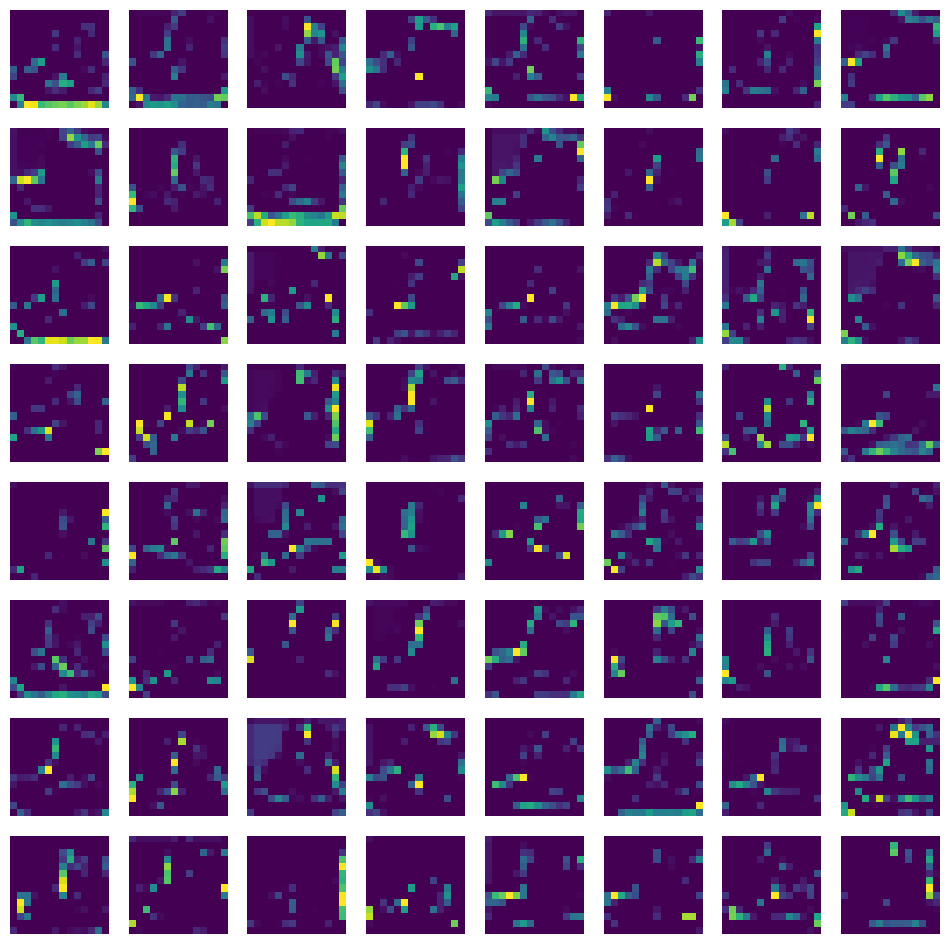

In [18]:
# 특성맵 확인
fig, axs = plt.subplots(8, 8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,i*8+j,:,:]) # [배치 index,channel index,height, width]
        axs[i,j].axis('off')
plt.show()